# 🌊 Complete Marine Workability Analysis - Learning Guide
## Step-by-step tutorial: From raw data to scatter diagrams

**What you'll learn:**
1. How to load and inspect ERA5 ocean data
2. How to clean and validate data
3. How to calculate wave statistics
4. How to create scatter diagrams (Hs vs Tp)
5. How to interpret results for marine operations

**Run each cell (Shift+Enter) and read the explanations!**

---
## Part 1: Setup and Load Libraries

First, we import the tools we need.

In [1]:
# Import libraries
import sys
from pathlib import Path

# Add our custom modules to the path
sys.path.insert(0, str(Path.cwd().parent))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xarray as xr

# Make plots look nice
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)

%matplotlib inline

print("✅ Libraries loaded successfully!")
print("\nWhat each library does:")
print("  • pandas: For working with tables of data")
print("  • numpy: For math and arrays")
print("  • matplotlib: For creating plots")
print("  • xarray: For working with NetCDF files (ocean/weather data)")

✅ Libraries loaded successfully!

What each library does:
  • pandas: For working with tables of data
  • numpy: For math and arrays
  • matplotlib: For creating plots
  • xarray: For working with NetCDF files (ocean/weather data)


---
## Part 2: Find Your Downloaded Data

Let's see what data files we have from 2015-2025.

In [2]:
# Find all the NetCDF files we downloaded
data_dir = Path('../data/raw/era5')
nc_files = sorted(data_dir.glob('*_merged.nc'))

print(f"📁 Found {len(nc_files)} data files:\n")

total_size_mb = 0
for i, file in enumerate(nc_files, 1):
    size_mb = file.stat().st_size / (1024 * 1024)
    total_size_mb += size_mb
    year = file.stem.split('_')[-2]
    print(f"  {i:2d}. Year {year}: {size_mb:5.2f} MB")

print(f"\n📊 Total data: {total_size_mb:.2f} MB")
print(f"\n💡 These files contain wave and wind data for your location")

📁 Found 11 data files:

   1. Year 2015:  0.51 MB
   2. Year 2016:  0.51 MB
   3. Year 2017:  0.51 MB
   4. Year 2018:  0.51 MB
   5. Year 2019:  0.51 MB
   6. Year 2020:  0.51 MB
   7. Year 2021:  0.51 MB
   8. Year 2022:  0.51 MB
   9. Year 2023:  0.51 MB
  10. Year 2024:  0.51 MB
  11. Year 2025:  0.45 MB

📊 Total data: 5.52 MB

💡 These files contain wave and wind data for your location


---
## Part 3: Look Inside One File

Let's open one file and see what's inside. Think of it like opening a spreadsheet.

In [3]:
# Open the first file (2015)
sample_file = nc_files[0]
print(f"Opening: {sample_file.name}\n")

ds = xr.open_dataset(sample_file)

print("📋 File contents:")
print(ds)

print("\n💡 Key things to notice:")
print("  • Dimensions: Shows how big the data is (time × lat × lon)")
print("  • Coordinates: The grid points (times, latitudes, longitudes)")
print("  • Data variables: The actual measurements (swh=wave height, u10/v10=wind, etc.)")

Opening: era5_UK_NortheastCoast_2015_merged.nc

📋 File contents:
<xarray.Dataset> Size: 765kB
Dimensions:     (valid_time: 1460, latitude: 5, longitude: 5)
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 12kB 2015-01-01 ... 2015-12-31T18...
  * latitude    (latitude) float64 40B 54.9 55.15 55.4 55.65 55.9
  * longitude   (longitude) float64 40B -0.5 -0.25 0.0 0.25 0.5
    number      int64 8B ...
    expver      (valid_time) <U4 23kB ...
Data variables:
    u10         (valid_time, latitude, longitude) float32 146kB ...
    v10         (valid_time, latitude, longitude) float32 146kB ...
    mwd         (valid_time, latitude, longitude) float32 146kB ...
    pp1d        (valid_time, latitude, longitude) float32 146kB ...
    swh         (valid_time, latitude, longitude) float32 146kB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7


In [4]:
# Let's understand each variable
print("📊 What each variable means:\n")

variables_explained = {
    'swh': 'Significant Wave Height (Hs) - Average height of highest 1/3 of waves',
    'pp1d': 'Peak Wave Period (Tp) - Time between wave crests',
    'mwd': 'Mean Wave Direction - Where waves are coming from',
    'u10': 'Wind U-component - East-West wind at 10m height',
    'v10': 'Wind V-component - North-South wind at 10m height'
}

for var, explanation in variables_explained.items():
    if var in ds.data_vars:
        units = ds[var].attrs.get('units', 'unknown')
        print(f"  {var:6s} → {explanation}")
        print(f"          Units: {units}\n")

ds.close()
print("✅ File closed")

📊 What each variable means:

  swh    → Significant Wave Height (Hs) - Average height of highest 1/3 of waves
          Units: m

  pp1d   → Peak Wave Period (Tp) - Time between wave crests
          Units: s

  mwd    → Mean Wave Direction - Where waves are coming from
          Units: Degree true

  u10    → Wind U-component - East-West wind at 10m height
          Units: m s**-1

  v10    → Wind V-component - North-South wind at 10m height
          Units: m s**-1

✅ File closed


---
## Part 4: Extract Data for YOUR Location

Now we'll extract the time series at your specific location for all years.

In [5]:
# Your location (UK Northeast Coast)
target_lat = 54.5   # degrees North
target_lon = -1.0   # degrees West (negative = West)

print(f"📍 Your location: {target_lat}°N, {abs(target_lon)}°W")
print(f"\n🌊 This is around Hartlepool/Middlesbrough area, UK")
print(f"\nNow extracting data for this location from all {len(nc_files)} years...\n")

# Store data from each year
all_years_data = []

for i, nc_file in enumerate(nc_files, 1):
    year = nc_file.stem.split('_')[-2]
    print(f"  [{i:2d}/{len(nc_files)}] Loading {year}...", end=" ")
    
    # Open file
    ds = xr.open_dataset(nc_file)
    
    # Extract at your location (nearest point)
    point = ds.sel(latitude=target_lat, longitude=target_lon, method='nearest')
    
    # Convert to pandas DataFrame (like a table)
    df_year = pd.DataFrame({
        'time': point['valid_time'].values,
        'hs': point['swh'].values,
        'tp': point['pp1d'].values,
        'dir': point['mwd'].values,
        'wind_u': point['u10'].values,
        'wind_v': point['v10'].values,
    })
    
    # Calculate wind speed from components
    # Wind speed = √(u² + v²)
    df_year['wind_speed'] = np.sqrt(df_year['wind_u']**2 + df_year['wind_v']**2)
    
    print(f"{len(df_year):,} records")
    
    all_years_data.append(df_year)
    ds.close()

print(f"\n✅ Loaded all {len(all_years_data)} years!")

📍 Your location: 54.5°N, 1.0°W

🌊 This is around Hartlepool/Middlesbrough area, UK

Now extracting data for this location from all 11 years...

  [ 1/11] Loading 2015... 1,460 records
  [ 2/11] Loading 2016... 1,464 records
  [ 3/11] Loading 2017... 1,460 records
  [ 4/11] Loading 2018... 1,460 records
  [ 5/11] Loading 2019... 1,460 records
  [ 6/11] Loading 2020... 1,464 records
  [ 7/11] Loading 2021... 1,460 records
  [ 8/11] Loading 2022... 1,460 records
  [ 9/11] Loading 2023... 1,460 records
  [10/11] Loading 2024... 1,464 records
  [11/11] Loading 2025... 1,247 records

✅ Loaded all 11 years!


---
## Part 5: Combine All Years Into One Dataset

Now we stack all years together to create one big dataset.

In [6]:
# Combine all years
print("Combining all years into one dataset...\n")
df_all = pd.concat(all_years_data, ignore_index=True)

# Sort by time
df_all = df_all.sort_values('time').reset_index(drop=True)

print("📊 Combined Dataset Info:")
print(f"  Total records: {len(df_all):,}")
print(f"  Start date: {df_all['time'].min()}")
print(f"  End date: {df_all['time'].max()}")
print(f"  Duration: {(df_all['time'].max() - df_all['time'].min()).days} days")
print(f"  ~{len(df_all) * 6:,} hours of data (6-hourly records)")

print("\n📋 Columns in dataset:")
for col in df_all.columns:
    print(f"  • {col}")

print("\n👀 First few rows:")
df_all.head(10)

Combining all years into one dataset...

📊 Combined Dataset Info:
  Total records: 15,859
  Start date: 2015-01-01 00:00:00
  End date: 2025-11-08 12:00:00
  Duration: 3964 days
  ~95,154 hours of data (6-hourly records)

📋 Columns in dataset:
  • time
  • hs
  • tp
  • dir
  • wind_u
  • wind_v
  • wind_speed

👀 First few rows:


,time,hs,tp,dir,wind_u,wind_v,wind_speed
0,2015-01-01 00:00:00,1.788754,5.521828,201.499268,5.959814,10.596545,12.157556
1,2015-01-01 06:00:00,1.297573,5.639015,202.063553,3.951309,8.450397,9.328561
2,2015-01-01 12:00:00,1.801332,5.402687,188.969910,3.231293,11.774301,12.209644
3,2015-01-01 18:00:00,2.500455,6.356300,198.457153,8.083596,11.590133,14.130666
4,2015-01-02 00:00:00,3.188416,6.959816,234.631287,15.009109,4.351538,15.627195
5,2015-01-02 06:00:00,3.181076,7.430031,273.532959,15.117712,1.079043,15.156172
6,2015-01-02 12:00:00,3.066653,7.266457,275.930176,15.337688,0.471368,15.344930
7,2015-01-02 18:00:00,2.753350,7.264503,276.752197,13.180245,2.452466,13.406471
8,2015-01-03 00:00:00,2.352761,6.183449,252.363937,10.677715,7.589931,13.100407
9,2015-01-03 06:00:00,1.825357,5.976418,259.111084,9.735943,3.267703,10.269687


---
## Part 6: Check Data Quality - Missing Values

Let's see if we have any missing data (NaN = "Not a Number" = missing).

In [7]:
print("=" * 80)
print("🔍 DATA QUALITY CHECK")
print("=" * 80)

print("\nMissing values in each column:\n")

for col in df_all.columns:
    if col == 'time':
        continue  # Skip time column
    
    missing_count = df_all[col].isna().sum()
    missing_pct = (missing_count / len(df_all)) * 100
    
    # Visual indicator
    if missing_pct == 0:
        status = "✅"
    elif missing_pct < 10:
        status = "⚠️"
    else:
        status = "❌"
    
    print(f"  {status} {col:12s}: {missing_count:6,} missing ({missing_pct:5.1f}%)")

print("\n💡 Explanation:")
print("  • 0% missing = Perfect! All data available")
print("  • <10% missing = Good, can interpolate")
print("  • >10% missing = Problematic, may need to investigate")

🔍 DATA QUALITY CHECK

Missing values in each column:

  ✅ hs          :      0 missing (  0.0%)
  ✅ tp          :      0 missing (  0.0%)
  ✅ dir         :      0 missing (  0.0%)
  ✅ wind_u      :      0 missing (  0.0%)
  ✅ wind_v      :      0 missing (  0.0%)
  ✅ wind_speed  :      0 missing (  0.0%)

💡 Explanation:
  • 0% missing = Perfect! All data available
  • <10% missing = Good, can interpolate
  • >10% missing = Problematic, may need to investigate


---
## Part 7: Clean the Data

Remove rows with missing wave data and check for unrealistic values.

In [8]:
print("🧹 Cleaning data...\n")
print(f"Before cleaning: {len(df_all):,} records")

# Remove rows where wave height or period is missing
df_clean = df_all.dropna(subset=['hs', 'tp']).copy()

print(f"After removing NaN: {len(df_clean):,} records")
print(f"Removed: {len(df_all) - len(df_clean):,} records ({(len(df_all)-len(df_clean))/len(df_all)*100:.1f}%)")

# Check for unrealistic values
print("\n🔍 Checking for unrealistic values...")

unrealistic = 0
if (df_clean['hs'] < 0).any():
    count = (df_clean['hs'] < 0).sum()
    print(f"  ⚠️ Found {count} negative wave heights (removing)")
    df_clean = df_clean[df_clean['hs'] >= 0]
    unrealistic += count

if (df_clean['hs'] > 20).any():
    count = (df_clean['hs'] > 20).sum()
    print(f"  ⚠️ Found {count} wave heights > 20m (extremely high, removing)")
    df_clean = df_clean[df_clean['hs'] <= 20]
    unrealistic += count

if unrealistic == 0:
    print("  ✅ All values within reasonable ranges!")

print(f"\nFinal cleaned dataset: {len(df_clean):,} records")
print(f"\n✅ Data is ready for analysis!")

🧹 Cleaning data...

Before cleaning: 15,859 records
After removing NaN: 15,859 records
Removed: 0 records (0.0%)

🔍 Checking for unrealistic values...
  ✅ All values within reasonable ranges!

Final cleaned dataset: 15,859 records

✅ Data is ready for analysis!


---
## Part 8: Basic Statistics

Let's understand what the typical conditions are at your location.

In [9]:
print("=" * 80)
print("📊 WAVE STATISTICS (2015-2025)")
print("=" * 80)

if len(df_clean) > 0 and 'hs' in df_clean.columns:
    print("\n🌊 Wave Height (Hs):")
    print(f"  Mean:         {df_clean['hs'].mean():.2f} m")
    print(f"  Median:       {df_clean['hs'].median():.2f} m")
    print(f"  Std Dev:      {df_clean['hs'].std():.2f} m")
    print(f"  Minimum:      {df_clean['hs'].min():.2f} m")
    print(f"  Maximum:      {df_clean['hs'].max():.2f} m")
    
    print("\n📈 Percentiles (what % of time waves are below this height):")
    for p in [10, 25, 50, 75, 90, 95, 99]:
        val = df_clean['hs'].quantile(p/100)
        print(f"  {p:2d}th percentile: {val:.2f} m")
    
    print("\n🌀 Wave Period (Tp):")
    if 'tp' in df_clean.columns:
        print(f"  Mean:         {df_clean['tp'].mean():.2f} s")
        print(f"  Median:       {df_clean['tp'].median():.2f} s")
        print(f"  Range:        {df_clean['tp'].min():.2f} - {df_clean['tp'].max():.2f} s")
    
    print("\n💨 Wind Speed:")
    if 'wind_speed' in df_clean.columns:
        print(f"  Mean:         {df_clean['wind_speed'].mean():.2f} m/s ({df_clean['wind_speed'].mean()*1.94384:.1f} knots)")
        print(f"  Maximum:      {df_clean['wind_speed'].max():.2f} m/s ({df_clean['wind_speed'].max()*1.94384:.1f} knots)")
        print(f"  95th %ile:    {df_clean['wind_speed'].quantile(0.95):.2f} m/s")
    
    print("\n💡 What this means:")
    print(f"  • Typical wave height: {df_clean['hs'].median():.2f}m (median)")
    print(f"  • 50% of time waves are below {df_clean['hs'].quantile(0.5):.2f}m")
    print(f"  • Only 5% of time waves exceed {df_clean['hs'].quantile(0.95):.2f}m")
else:
    print("\n❌ No valid data to analyze!")

📊 WAVE STATISTICS (2015-2025)

🌊 Wave Height (Hs):
  Mean:         1.34 m
  Median:       1.16 m
  Std Dev:      0.81 m
  Minimum:      0.13 m
  Maximum:      7.65 m

📈 Percentiles (what % of time waves are below this height):
  10th percentile: 0.53 m
  25th percentile: 0.77 m
  50th percentile: 1.16 m
  75th percentile: 1.71 m
  90th percentile: 2.36 m
  95th percentile: 2.89 m
  99th percentile: 4.15 m

🌀 Wave Period (Tp):
  Mean:         7.01 s
  Median:       6.47 s
  Range:        2.30 - 18.22 s

💨 Wind Speed:
  Mean:         7.42 m/s (14.4 knots)
  Maximum:      21.82 m/s (42.4 knots)
  95th %ile:    13.26 m/s

💡 What this means:
  • Typical wave height: 1.16m (median)
  • 50% of time waves are below 1.16m
  • Only 5% of time waves exceed 2.89m


---
## Part 9: Wave Height Distribution

What percentage of time are waves below certain heights? This is crucial for workability!

WAVE HEIGHT DISTRIBUTION (histogram‑based)

% of time waves are BELOW these heights:

  Hs <  0.5m :  11.3% █████
  Hs <  1.0m :  43.2% █████████████████████
  Hs <  1.5m :  69.5% ██████████████████████████████████
  Hs <  2.0m :  84.4% ██████████████████████████████████████████
  Hs <  2.5m :  92.3% ██████████████████████████████████████████████
  Hs <  3.0m :  95.8% ███████████████████████████████████████████████
  Hs <  3.5m :  97.8% ████████████████████████████████████████████████
  Hs <  4.0m :  98.9% █████████████████████████████████████████████████
  Hs <  5.0m :  99.7% █████████████████████████████████████████████████


C:\Users\k.jonathan\AppData\Local\Temp\ipykernel_28924\3586591941.py:45: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


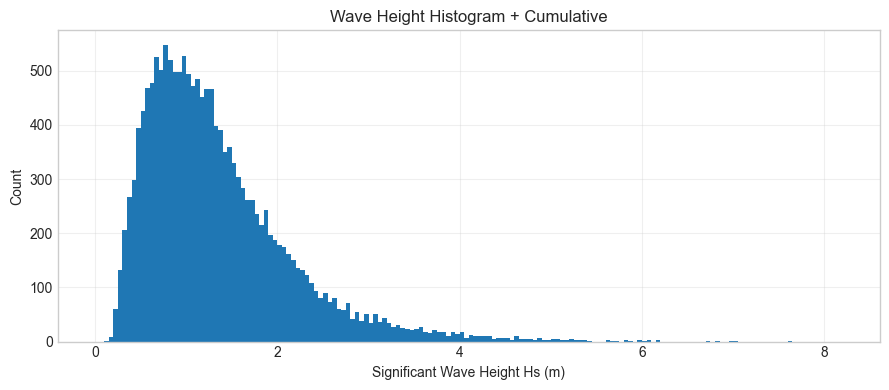

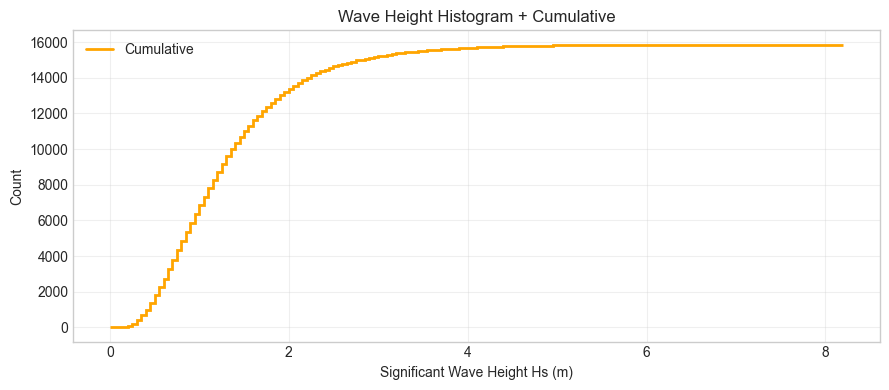

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt   # optional – for a quick plot


max_hs = df_clean['hs'].max()
bin_edges = np.arange(0, max_hs + 0.6, 0.05)      # e.g. [0,0.5,1.0,...,max+0.5]

# -------------------------------------------------
# 3. BUILD HISTOGRAM + CUMULATIVE %
# -------------------------------------------------
counts, _ = np.histogram(df_clean['hs'], bins=bin_edges)
cum_counts = np.cumsum(counts)                 # number of obs <= upper edge of each bin
total = len(df_clean)
cum_percent = cum_counts / total * 100

# -------------------------------------------------
# 4. PRETTY PRINT (same style you liked)
# -------------------------------------------------
print("=" * 80)
print("WAVE HEIGHT DISTRIBUTION (histogram‑based)")
print("=" * 80)
print("\n% of time waves are BELOW these heights:\n")

# Thresholds you care about (must be inside bin_edges)
thresholds = [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 5.0]

for th in thresholds:
    # Find the first bin edge that is >= th  →  index i
    i = np.searchsorted(bin_edges, th, side='right') - 1
    pct = cum_percent[i] if i < len(cum_percent) else 100.0

    bar_len = int(pct / 2)
    bar = '█' * bar_len
    print(f"  Hs < {th:4.1f}m : {pct:5.1f}% {bar}")

# -------------------------------------------------
# 6. OPTIONAL: QUICK HISTOGRAM PLOT
# -------------------------------------------------
plt.figure(figsize=(9,4))
plt.stairs(counts, bin_edges, fill=True, color='#1f77b4', edgecolor='black')
plt.title('Wave Height Histogram + Cumulative')
plt.xlabel('Significant Wave Height Hs (m)')
plt.ylabel('Count')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

plt.figure(figsize=(9,4))
plt.stairs(cum_counts, bin_edges, baseline=None,
            fill=False, color='orange', linewidth=2, label='Cumulative')
plt.title('Wave Height Histogram + Cumulative')
plt.xlabel('Significant Wave Height Hs (m)')
plt.ylabel('Count')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

---
## Part 10: Visualize Time Series

Let's see what the waves looked like over the 10 years!

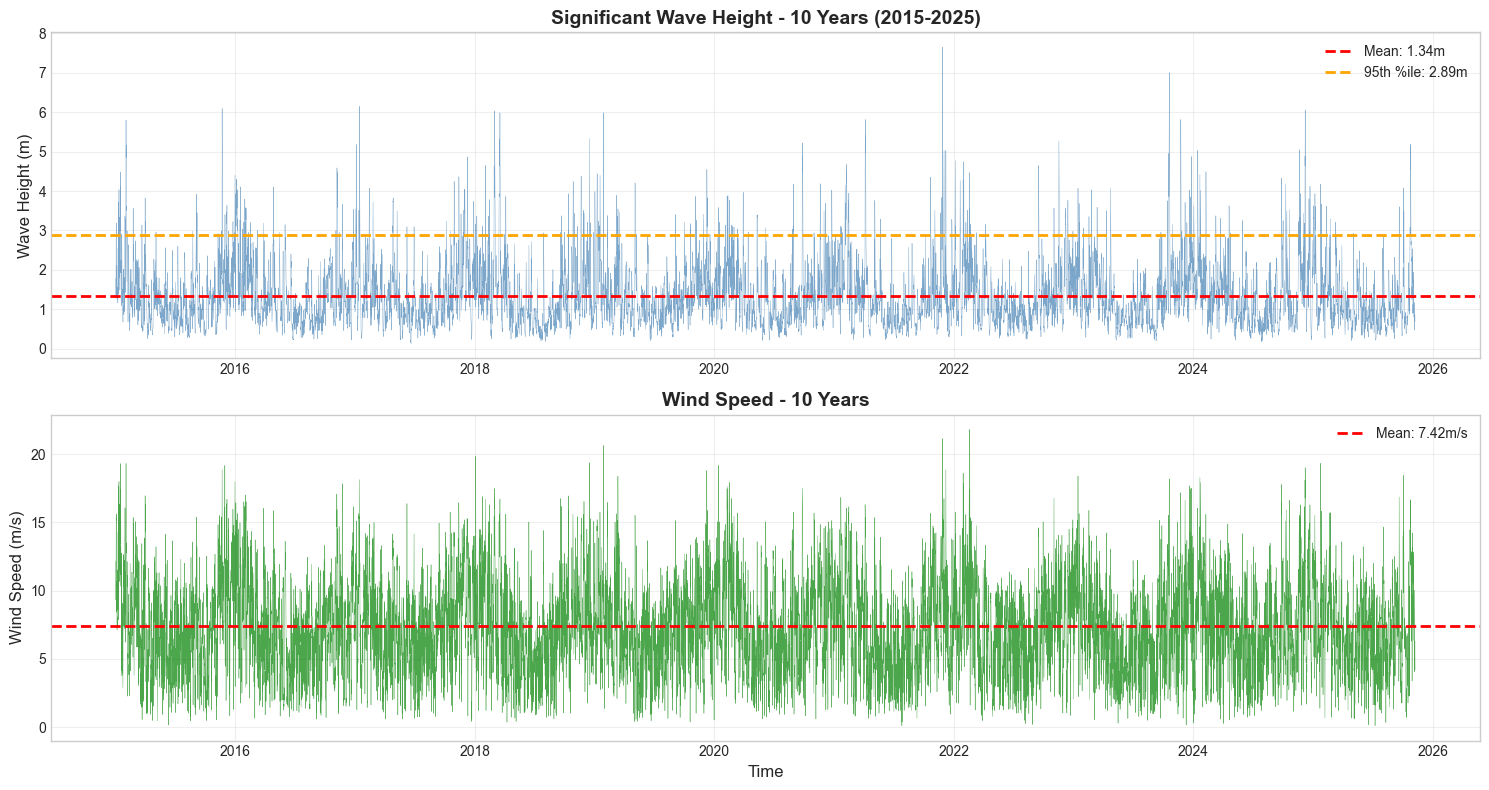

💡 Notice the seasonal patterns:
  • Higher waves in winter (Nov-Mar)
  • Calmer in summer (May-Sep)


In [15]:
# Plot complete time series
fig, axes = plt.subplots(2, 1, figsize=(15, 8))

# Wave height
axes[0].plot(df_clean['time'], df_clean['hs'], linewidth=0.3, alpha=0.7, color='steelblue')
axes[0].axhline(df_clean['hs'].mean(), color='red', linestyle='--', linewidth=2, 
                label=f'Mean: {df_clean["hs"].mean():.2f}m')
axes[0].axhline(df_clean['hs'].quantile(0.95), color='orange', linestyle='--', linewidth=2,
                label=f'95th %ile: {df_clean["hs"].quantile(0.95):.2f}m')
axes[0].set_ylabel('Wave Height (m)', fontsize=12)
axes[0].set_title('Significant Wave Height - 10 Years (2015-2025)', fontsize=14, fontweight='bold')
axes[0].legend(loc='upper right')
axes[0].grid(True, alpha=0.3)

# Wind speed
axes[1].plot(df_clean['time'], df_clean['wind_speed'], linewidth=0.3, alpha=0.7, color='green')
axes[1].axhline(df_clean['wind_speed'].mean(), color='red', linestyle='--', linewidth=2,
                label=f'Mean: {df_clean["wind_speed"].mean():.2f}m/s')
axes[1].set_xlabel('Time', fontsize=12)
axes[1].set_ylabel('Wind Speed (m/s)', fontsize=12)
axes[1].set_title('Wind Speed - 10 Years', fontsize=14, fontweight='bold')
axes[1].legend(loc='upper right')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("💡 Notice the seasonal patterns:")
print("  • Higher waves in winter (Nov-Mar)")
print("  • Calmer in summer (May-Sep)")

---
## Part 11: Distribution Histograms

Histograms show us how often different wave heights and periods occur.

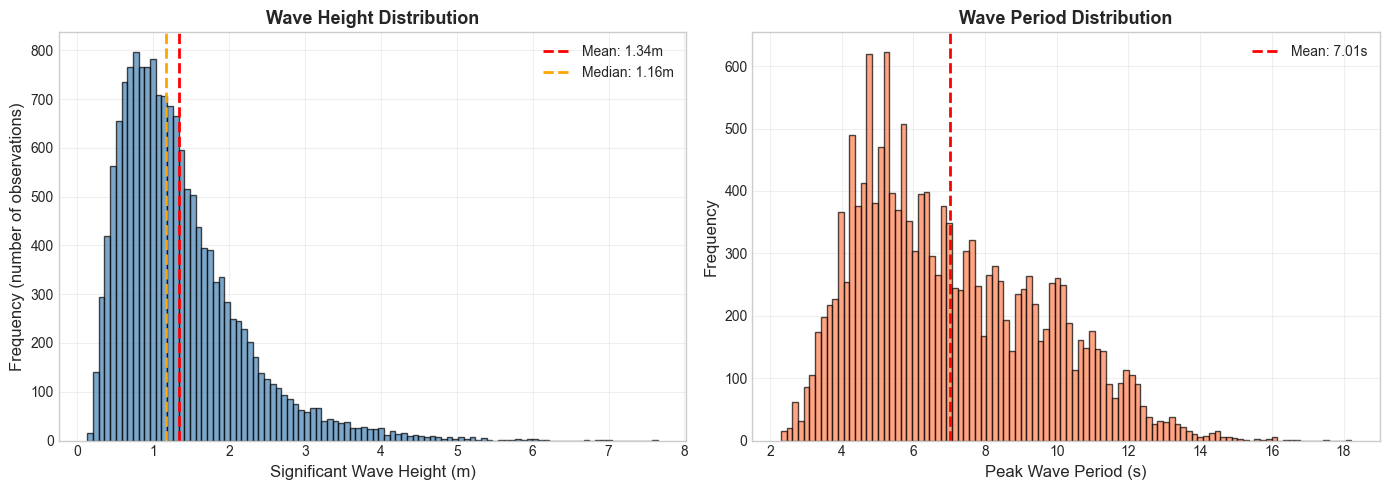

💡 Reading histograms:
  • Tall bars = Common conditions
  • Short bars = Rare conditions
  • Most waves are 0.5-2.5m (typical for North Sea)


In [17]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Wave height histogram
axes[0].hist(df_clean['hs'], bins=100, edgecolor='black', alpha=0.7, color='steelblue')
axes[0].axvline(df_clean['hs'].mean(), color='red', linestyle='--', linewidth=2,
                label=f'Mean: {df_clean["hs"].mean():.2f}m')
axes[0].axvline(df_clean['hs'].median(), color='orange', linestyle='--', linewidth=2,
                label=f'Median: {df_clean["hs"].median():.2f}m')
axes[0].set_xlabel('Significant Wave Height (m)', fontsize=12)
axes[0].set_ylabel('Frequency (number of observations)', fontsize=12)
axes[0].set_title('Wave Height Distribution', fontsize=13, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Wave period histogram
axes[1].hist(df_clean['tp'], bins=100, edgecolor='black', alpha=0.7, color='coral')
axes[1].axvline(df_clean['tp'].mean(), color='red', linestyle='--', linewidth=2,
                label=f'Mean: {df_clean["tp"].mean():.2f}s')
axes[1].set_xlabel('Peak Wave Period (s)', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].set_title('Wave Period Distribution', fontsize=13, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("💡 Reading histograms:")
print("  • Tall bars = Common conditions")
print("  • Short bars = Rare conditions")
print("  • Most waves are 0.5-2.5m (typical for North Sea)")

---
## Part 12: Scatter Diagram (Hs vs Tp)

**This is the KEY output for workability analysis!**

A scatter diagram shows how often each combination of wave height (Hs) and wave period (Tp) occurs.

In [18]:
print("=" * 80)
print("🎯 CREATING SCATTER DIAGRAM")
print("=" * 80)

print("\nWhat is a scatter diagram?")
print("  • It's a table showing frequency of wave height + period combinations")
print("  • Each 'cell' represents a range (e.g., Hs=1.0-1.5m, Tp=6-7s)")
print("  • The number in each cell = hours per year that condition occurs")
print("  • Used to calculate workability %")

print("\nGenerating scatter diagram...")

# Define bins
hs_bins = np.arange(0, 10.5, 0.5)  # 0-0.5m, 0.5-1.0m, etc.
tp_bins = np.arange(0, 21, 1)      # 0-1s, 1-2s, etc.

# Create 2D histogram
hist, hs_edges, tp_edges = np.histogram2d(
    df_clean['hs'],
    df_clean['tp'],
    bins=[hs_bins, tp_bins]
)

# Convert to DataFrame
scatter_data = []
for i in range(len(hs_bins) - 1):
    for j in range(len(tp_bins) - 1):
        frequency = hist[i, j]
        if frequency > 0:  # Only keep non-zero cells
            hs_center = (hs_bins[i] + hs_bins[i+1]) / 2
            tp_center = (tp_bins[j] + tp_bins[j+1]) / 2
            
            scatter_data.append({
                'hs_bin': hs_center,
                'tp_bin': tp_center,
                'hs_lower': hs_bins[i],
                'hs_upper': hs_bins[i+1],
                'tp_lower': tp_bins[j],
                'tp_upper': tp_bins[j+1],
                'frequency': int(frequency),
                'percentage': frequency / len(df_clean) * 100
            })

scatter_df = pd.DataFrame(scatter_data)

# Sort by frequency
scatter_df = scatter_df.sort_values('frequency', ascending=False).reset_index(drop=True)

print(f"\n✅ Scatter diagram created!")
print(f"  Non-zero cells: {len(scatter_df)}")
print(f"  Total frequency: {scatter_df['frequency'].sum():,}")

🎯 CREATING SCATTER DIAGRAM

What is a scatter diagram?
  • It's a table showing frequency of wave height + period combinations
  • Each 'cell' represents a range (e.g., Hs=1.0-1.5m, Tp=6-7s)
  • The number in each cell = hours per year that condition occurs
  • Used to calculate workability %

Generating scatter diagram...

✅ Scatter diagram created!
  Non-zero cells: 126
  Total frequency: 15,859


In [19]:
# Show most frequent sea states
print("=" * 80)
print("🌊 TOP 20 MOST FREQUENT SEA STATES")
print("=" * 80)
print("\nThese are the conditions you'll see most often at your location:\n")

top20 = scatter_df.head(20)[['hs_bin', 'tp_bin', 'frequency', 'percentage']]
print(top20.to_string(index=False))

print(f"\n💡 The top 20 states represent {top20['percentage'].sum():.1f}% of all conditions")
print(f"\nMost common: Hs={scatter_df.iloc[0]['hs_bin']:.1f}m, Tp={scatter_df.iloc[0]['tp_bin']:.0f}s")
print(f"This occurs {scatter_df.iloc[0]['frequency']:.0f} times ({scatter_df.iloc[0]['percentage']:.2f}% of time)")

🌊 TOP 20 MOST FREQUENT SEA STATES

These are the conditions you'll see most often at your location:

 hs_bin  tp_bin  frequency  percentage
   0.75     4.5       1077    6.791097
   1.25     4.5       1068    6.734346
   0.75     3.5        923    5.820039
   1.25     5.5        907    5.719150
   1.75     5.5        787    4.962482
   0.75     5.5        761    4.798537
   0.75     6.5        584    3.682452
   1.25     7.5        469    2.957311
   1.25     6.5        464    2.925783
   1.75     6.5        433    2.730311
   2.25     6.5        397    2.503310
   0.75     9.5        382    2.408727
   1.25     8.5        369    2.326755
   1.25     9.5        349    2.200643
   0.25     4.5        346    2.181726
   0.75    10.5        342    2.156504
   0.75     8.5        342    2.156504
   0.75     7.5        324    2.043004
   1.25    10.5        302    1.904281
   1.75     7.5        300    1.891670

💡 The top 20 states represent 68.9% of all conditions

Most common: Hs=0.8m, Tp

---
## Part 13: Visualize Scatter Diagram

Let's create visual representations of the scatter diagram.

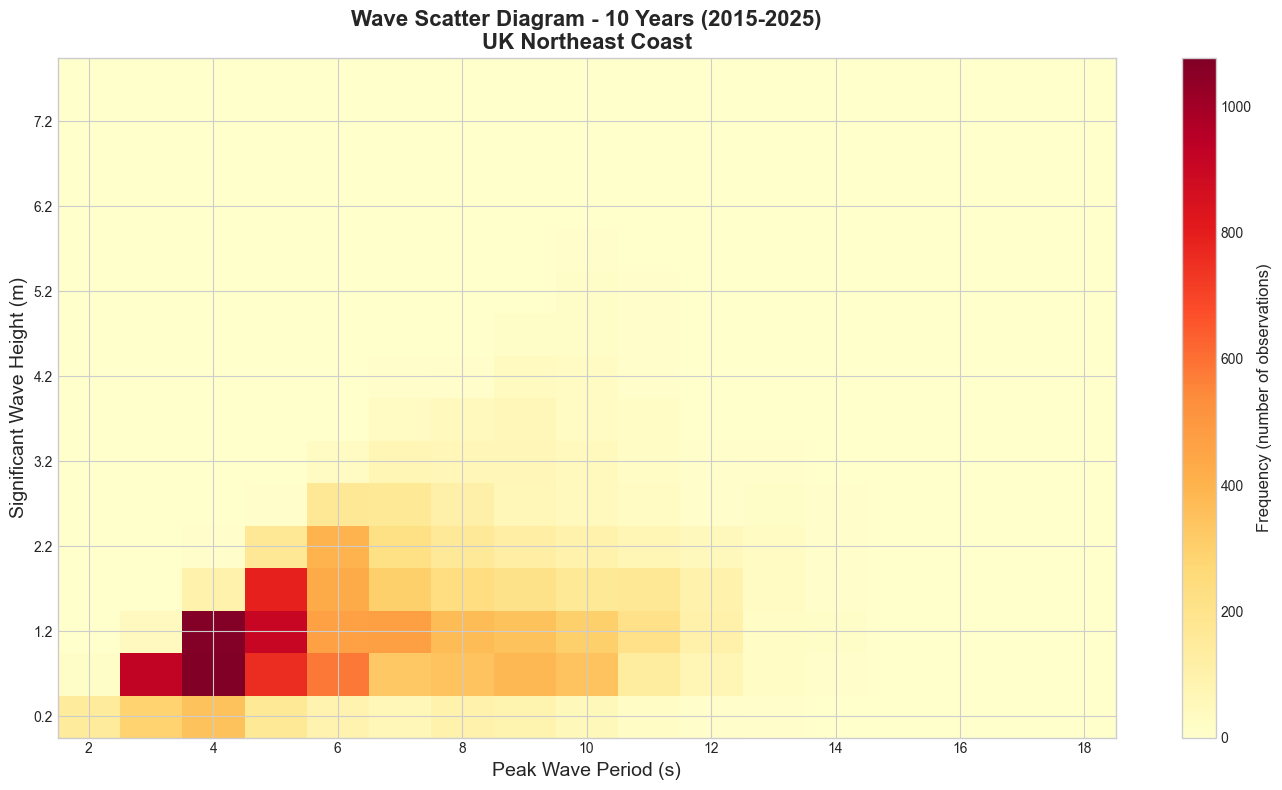

💡 Reading this plot:
  • Red/Orange = Common conditions
  • Yellow = Less common
  • White = Rare or never occurs
  • Most activity is in lower-left (smaller waves, shorter periods)


In [20]:
# Method 1: Heatmap
fig, ax = plt.subplots(figsize=(14, 8))

# Create pivot table
scatter_pivot = scatter_df.pivot_table(
    values='frequency',
    index='hs_bin',
    columns='tp_bin',
    fill_value=0
)

# Plot
im = ax.imshow(scatter_pivot.values, aspect='auto', origin='lower', cmap='YlOrRd')

# Labels
ax.set_xticks(range(0, len(scatter_pivot.columns), 2))
ax.set_xticklabels([f"{scatter_pivot.columns[i]:.0f}" for i in range(0, len(scatter_pivot.columns), 2)])
ax.set_yticks(range(0, len(scatter_pivot.index), 2))
ax.set_yticklabels([f"{scatter_pivot.index[i]:.1f}" for i in range(0, len(scatter_pivot.index), 2)])

ax.set_xlabel('Peak Wave Period (s)', fontsize=14)
ax.set_ylabel('Significant Wave Height (m)', fontsize=14)
ax.set_title('Wave Scatter Diagram - 10 Years (2015-2025)\nUK Northeast Coast', 
             fontsize=16, fontweight='bold')

# Colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Frequency (number of observations)', fontsize=12)

plt.tight_layout()
plt.show()

print("💡 Reading this plot:")
print("  • Red/Orange = Common conditions")
print("  • Yellow = Less common")
print("  • White = Rare or never occurs")
print("  • Most activity is in lower-left (smaller waves, shorter periods)")

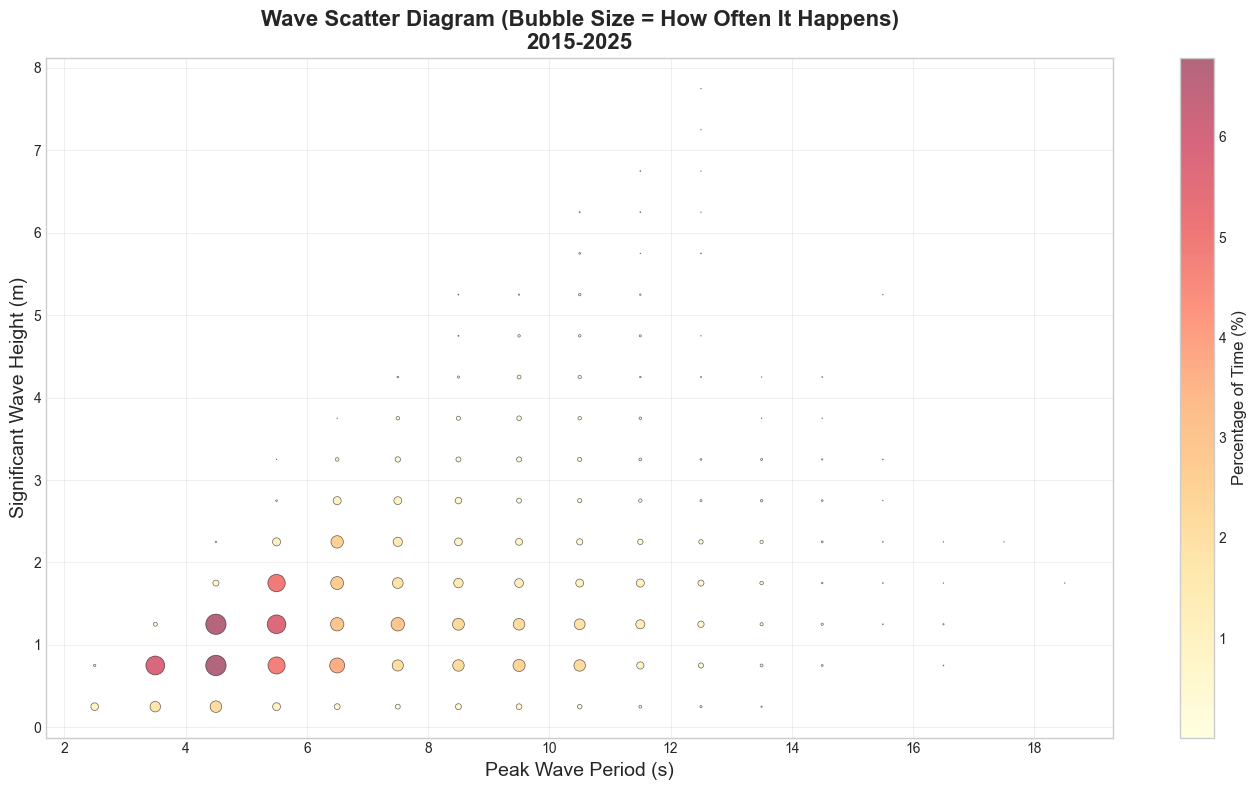

💡 Reading this plot:
  • Bigger bubbles = More frequent
  • Warmer colors (red) = Higher percentage of time
  • Clustering shows typical sea states


In [21]:
# Method 2: Bubble plot
fig, ax = plt.subplots(figsize=(14, 8))

scatter = ax.scatter(
    scatter_df['tp_bin'],
    scatter_df['hs_bin'],
    s=scatter_df['frequency']/5,    # Bubble size = frequency
    c=scatter_df['percentage'],      # Color = percentage
    cmap='YlOrRd',
    alpha=0.6,
    edgecolors='black',
    linewidth=0.5
)

ax.set_xlabel('Peak Wave Period (s)', fontsize=14)
ax.set_ylabel('Significant Wave Height (m)', fontsize=14)
ax.set_title('Wave Scatter Diagram (Bubble Size = How Often It Happens)\n2015-2025', 
             fontsize=16, fontweight='bold')
ax.grid(True, alpha=0.3)

cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Percentage of Time (%)', fontsize=12)

plt.tight_layout()
plt.show()

print("💡 Reading this plot:")
print("  • Bigger bubbles = More frequent")
print("  • Warmer colors (red) = Higher percentage of time")
print("  • Clustering shows typical sea states")

---
## Part 14: Monthly Analysis

How do conditions vary by month?

In [22]:
# Add month column
df_clean['month'] = pd.to_datetime(df_clean['time']).dt.month
df_clean['month_name'] = pd.to_datetime(df_clean['time']).dt.strftime('%b')

# Calculate monthly statistics
monthly_stats = df_clean.groupby('month').agg({
    'hs': ['mean', 'max', 'count'],
    'wind_speed': 'mean'
}).round(2)

# Add month names
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

print("=" * 80)
print("📅 MONTHLY STATISTICS")
print("=" * 80)
print("\nAverage conditions by month:\n")

for month, name in enumerate(month_names, 1):
    if month in monthly_stats.index:
        mean_hs = monthly_stats.loc[month, ('hs', 'mean')]
        max_hs = monthly_stats.loc[month, ('hs', 'max')]
        mean_wind = monthly_stats.loc[month, ('wind_speed', 'mean')]
        count = monthly_stats.loc[month, ('hs', 'count')]
        
        print(f"  {name}: Mean Hs={mean_hs:4.2f}m, Max Hs={max_hs:4.2f}m, "
              f"Mean Wind={mean_wind:4.2f}m/s, Records={count:.0f}")

📅 MONTHLY STATISTICS

Average conditions by month:

  Jan: Mean Hs=1.82m, Max Hs=6.15m, Mean Wind=9.18m/s, Records=1364
  Feb: Mean Hs=1.72m, Max Hs=5.80m, Mean Wind=9.10m/s, Records=1244
  Mar: Mean Hs=1.49m, Max Hs=6.03m, Mean Wind=7.67m/s, Records=1364
  Apr: Mean Hs=1.30m, Max Hs=5.81m, Mean Wind=6.67m/s, Records=1320
  May: Mean Hs=1.07m, Max Hs=4.21m, Mean Wind=6.04m/s, Records=1364
  Jun: Mean Hs=0.93m, Max Hs=3.10m, Mean Wind=5.98m/s, Records=1320
  Jul: Mean Hs=0.85m, Max Hs=2.94m, Mean Wind=5.79m/s, Records=1364
  Aug: Mean Hs=0.93m, Max Hs=4.18m, Mean Wind=6.34m/s, Records=1364
  Sep: Mean Hs=1.17m, Max Hs=5.22m, Mean Wind=7.02m/s, Records=1320
  Oct: Mean Hs=1.49m, Max Hs=7.00m, Mean Wind=7.95m/s, Records=1364
  Nov: Mean Hs=1.67m, Max Hs=7.65m, Mean Wind=8.70m/s, Records=1231
  Dec: Mean Hs=1.72m, Max Hs=6.06m, Mean Wind=8.92m/s, Records=1240


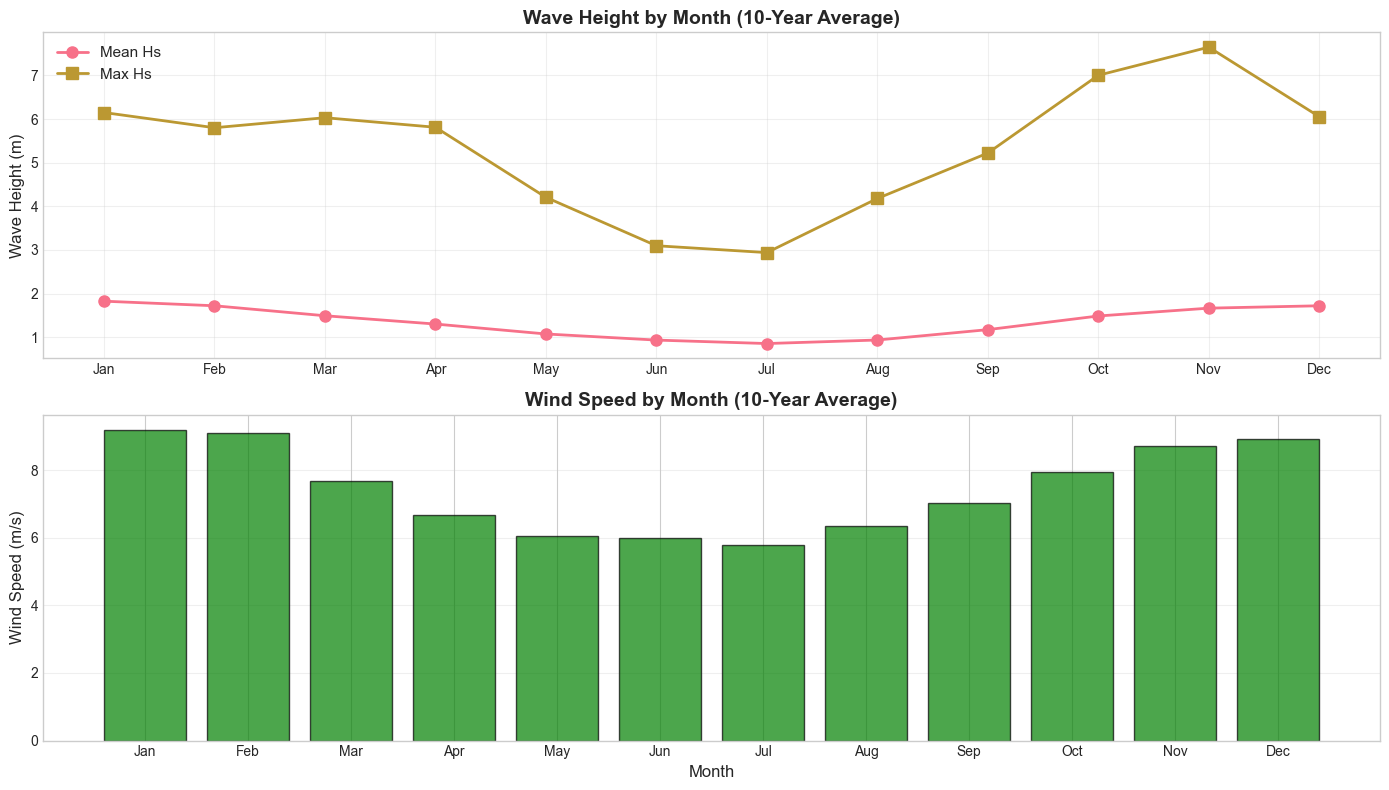

💡 Seasonal patterns:
  • Winter (Nov-Mar): Mean Hs = 1.68m
  • Summer (May-Sep): Mean Hs = 0.99m
  • Winter is 1.7x rougher than summer


In [23]:
# Plot monthly trends
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

monthly_mean = df_clean.groupby('month')['hs'].mean()
monthly_max = df_clean.groupby('month')['hs'].max()

months = range(1, 13)
month_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# Wave height by month
axes[0].plot(months, monthly_mean, 'o-', linewidth=2, markersize=8, label='Mean Hs')
axes[0].plot(months, monthly_max, 's-', linewidth=2, markersize=8, label='Max Hs')
axes[0].set_xticks(months)
axes[0].set_xticklabels(month_labels)
axes[0].set_ylabel('Wave Height (m)', fontsize=12)
axes[0].set_title('Wave Height by Month (10-Year Average)', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Wind speed by month
monthly_wind = df_clean.groupby('month')['wind_speed'].mean()
axes[1].bar(months, monthly_wind, color='green', alpha=0.7, edgecolor='black')
axes[1].set_xticks(months)
axes[1].set_xticklabels(month_labels)
axes[1].set_ylabel('Wind Speed (m/s)', fontsize=12)
axes[1].set_xlabel('Month', fontsize=12)
axes[1].set_title('Wind Speed by Month (10-Year Average)', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("💡 Seasonal patterns:")
winter_months = [11, 12, 1, 2, 3]
summer_months = [5, 6, 7, 8, 9]

winter_mean = df_clean[df_clean['month'].isin(winter_months)]['hs'].mean()
summer_mean = df_clean[df_clean['month'].isin(summer_months)]['hs'].mean()

print(f"  • Winter (Nov-Mar): Mean Hs = {winter_mean:.2f}m")
print(f"  • Summer (May-Sep): Mean Hs = {summer_mean:.2f}m")
print(f"  • Winter is {winter_mean/summer_mean:.1f}x rougher than summer")

---
## Part 15: Save Your Results

Let's save the processed data and scatter diagram for future use.

In [24]:
print("💾 Saving results...\n")

# Create output directories
output_ts = Path('../data/processed/timeseries')
output_sc = Path('../data/processed/scatter_diagrams')
output_ts.mkdir(parents=True, exist_ok=True)
output_sc.mkdir(parents=True, exist_ok=True)

# Save time series
ts_file = output_ts / 'UK_NortheastCoast_2015_2025_cleaned.parquet'
df_clean.to_parquet(ts_file, index=False)
print(f"✅ Time series saved: {ts_file}")
print(f"   Size: {ts_file.stat().st_size / (1024*1024):.2f} MB")

# Save scatter diagram (CSV for easy viewing)
sc_csv = output_sc / 'UK_NortheastCoast_2015_2025_scatter.csv'
scatter_df.to_csv(sc_csv, index=False)
print(f"\n✅ Scatter diagram saved: {sc_csv}")
print(f"   You can open this in Excel!")

# Save scatter diagram (Parquet for Python)
sc_parquet = output_sc / 'UK_NortheastCoast_2015_2025_scatter.parquet'
scatter_df.to_parquet(sc_parquet, index=False)
print(f"\n✅ Scatter diagram saved: {sc_parquet}")

print("\n" + "=" * 80)
print("✅ ALL FILES SAVED!")
print("=" * 80)

💾 Saving results...

✅ Time series saved: ..\data\processed\timeseries\UK_NortheastCoast_2015_2025_cleaned.parquet
   Size: 0.65 MB

✅ Scatter diagram saved: ..\data\processed\scatter_diagrams\UK_NortheastCoast_2015_2025_scatter.csv
   You can open this in Excel!

✅ Scatter diagram saved: ..\data\processed\scatter_diagrams\UK_NortheastCoast_2015_2025_scatter.parquet

✅ ALL FILES SAVED!


---
## Part 16: Final Summary

Let's summarize everything we learned!

In [25]:
print("=" * 80)
print("🎓 FINAL SUMMARY - WHAT WE LEARNED")
print("=" * 80)

print(f"\n📍 Location: {target_lat}°N, {abs(target_lon)}°W (UK Northeast Coast)")
print(f"📅 Period: 2015-2025 (10+ years)")
print(f"📊 Total records: {len(df_clean):,} (6-hourly observations)")
print(f"⏱️  Equivalent: {len(df_clean) * 6:,} hours of data")

print("\n🌊 KEY WAVE STATISTICS:")
print(f"  • Mean wave height: {df_clean['hs'].mean():.2f} m")
print(f"  • Median wave height: {df_clean['hs'].median():.2f} m")
print(f"  • Maximum recorded: {df_clean['hs'].max():.2f} m")
print(f"  • 95th percentile: {df_clean['hs'].quantile(0.95):.2f} m")
print(f"  • Typical period: {df_clean['tp'].mean():.2f} s")

print("\n💡 PRACTICAL INSIGHTS:")
pct_1_5 = (df_clean['hs'] < 1.5).sum() / len(df_clean) * 100
pct_2_5 = (df_clean['hs'] < 2.5).sum() / len(df_clean) * 100
pct_3_0 = (df_clean['hs'] < 3.0).sum() / len(df_clean) * 100

print(f"  • Waves < 1.5m: {pct_1_5:.1f}% of time (~{pct_1_5/100*365:.0f} days/year)")
print(f"  • Waves < 2.5m: {pct_2_5:.1f}% of time (~{pct_2_5/100*365:.0f} days/year)")
print(f"  • Waves < 3.0m: {pct_3_0:.1f}% of time (~{pct_3_0/100*365:.0f} days/year)")

print("\n📈 SCATTER DIAGRAM:")
print(f"  • Non-zero cells: {len(scatter_df)}")
print(f"  • Most common state: Hs={scatter_df.iloc[0]['hs_bin']:.1f}m, Tp={scatter_df.iloc[0]['tp_bin']:.0f}s")
print(f"  • Occurs: {scatter_df.iloc[0]['percentage']:.2f}% of time")

print("\n🎯 NEXT STEPS - WORKABILITY ANALYSIS:")
print("  1. Define operational limits (e.g., max Hs for crane ops)")
print("  2. Calculate workability % from scatter diagram")
print("  3. Compare different vessel types and operations")
print("  4. Generate reports for project planning")

print("\n" + "=" * 80)
print("✅ CONGRATULATIONS!")
print("=" * 80)
print("\nYou now understand:")
print("  ✓ How to load and process ocean data")
print("  ✓ How to calculate wave statistics")
print("  ✓ How to create scatter diagrams")
print("  ✓ How to interpret results for marine operations")
print("\nYou're ready for Phase 2: Workability Calculations! 🚀")

🎓 FINAL SUMMARY - WHAT WE LEARNED

📍 Location: 54.5°N, 1.0°W (UK Northeast Coast)
📅 Period: 2015-2025 (10+ years)
📊 Total records: 15,859 (6-hourly observations)
⏱️  Equivalent: 95,154 hours of data

🌊 KEY WAVE STATISTICS:
  • Mean wave height: 1.34 m
  • Median wave height: 1.16 m
  • Maximum recorded: 7.65 m
  • 95th percentile: 2.89 m
  • Typical period: 7.01 s

💡 PRACTICAL INSIGHTS:
  • Waves < 1.5m: 67.4% of time (~246 days/year)
  • Waves < 2.5m: 91.7% of time (~335 days/year)
  • Waves < 3.0m: 95.6% of time (~349 days/year)

📈 SCATTER DIAGRAM:
  • Non-zero cells: 126
  • Most common state: Hs=0.8m, Tp=4s
  • Occurs: 6.79% of time

🎯 NEXT STEPS - WORKABILITY ANALYSIS:
  1. Define operational limits (e.g., max Hs for crane ops)
  2. Calculate workability % from scatter diagram
  3. Compare different vessel types and operations
  4. Generate reports for project planning

✅ CONGRATULATIONS!

You now understand:
  ✓ How to load and process ocean data
  ✓ How to calculate wave statist